# Problem 1: CIFAR10 CNN: training using minibatch gradient descent algorithms

## 0. Set up

In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
pip install --upgrade visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 17.7 MB/s eta 0:00:00


In [ ]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import visualkeras

# Deep learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D, SpatialDropout2D, AveragePooling2D
from tensorflow.keras import Input, regularizers, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.utils import plot_model

# Data preprocessing
from keras.utils import to_categorical

# Hyperparameters tuning modules
import kerastuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

<ipython-input-3-d8ad12815fc8>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## 1. Data loading and preprocessing

In [ ]:
# Load the dataset and split into training/testing features and labels
from keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

# Data normalization
data_train, data_test = data_train / 255.0, data_test / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
data_train.shape

(50000, 32, 32, 3)

In [ ]:
# One-hot encoding for labels (As I am using Categorical Crossentropy for loss function, instead of Sparse)
label_train = to_categorical(label_train, 10)
label_test = to_categorical(label_test, 10)
label_test.shape[-1]

10

## 2. Set hyperparameters

**Set hyperparameters as followed:**
*   batch_size = 128
*   learning_rate = 0.001
*   epoches = 100
*   dropout = [0.1, 0.3, 0.5, 0.7]

In [ ]:
# Define some hyperparameters for model definition
batch_size = 128
learning_rate = 0.001
n_epoch = 100
dropout = [a for a in np.arange(0.1, 1, 0.2)]

In [ ]:
# For plotting purposes
optimizer_names = ['GD','Adagrad','RMSprop','Nesterov','Adam']

# Methods to be tested along with any specific parameter
optimizer_list = [keras.optimizers.SGD(learning_rate=learning_rate), 'Adagrad', 'RMSprop', keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True),'Adam']

In [ ]:
n_features = data_train.shape[1:]

n_classes = label_train.shape[-1]

##3. Building Convolutional Neural Network (CNN) models

Here, I first implement a CNN architecture that consists of 3 convolutional layers followed by a fully connected layer of 1000 units, under the conditions below:

3x32x32-32C5-P2-64C5-P2-128C5-P2-1000N-10N

*  Convolutional Filters Size : 5x5
*  Convolutional Stride : (1, 1)
*  Max-Pool Size : 2x2
*  Max-Pool Stride : (2, 2)
*  Activation Function : ReLU

###Step 1: Compare Optimization Algorithms


---


* Mini-batch gradient descent
* Mini-batch AdaGrad
* Mini-batch RMSProp
* Mini-batch gradient descent with Nesterov’s momentum
* Mini-batch Adam

First, to compare optimization techniques, **I first applied dropout only at the end of the fully connected layers, using a dropout rate of 0.3.** This decisi convolutional layers already contain significantly fewer trainable parameters. In CNNs, the convolutional filter operates uniformly across every region of the image (translation equivariance), and each kernel focuses on local pixel regions (locality principle). This shared-filter architecture reduces both the number of parameters and the risk of overfitting, making additional weight removal through dropout less desirable.

Additionally, to obtain the average training loss per epoch versus the number of epochs for the training dataset, I set **steps_per_epoch=50 and shuffle=True.**

In [ ]:
def build_compile(optimizer_list='GD'):
    model_base = Sequential()

    # First Convoluntional layer
    model_base.add(Conv2D(36, (5,5), input_shape=n_features, padding='same', activation='relu')) # default for stride as (1, 1)
    model_base.add(MaxPooling2D(strides=(2, 2))) # default for pool_size and padding as "valid"

    # Second Convoluntional layer
    model_base.add(Conv2D(64, (5,5), padding='same', activation='relu'))
    model_base.add(MaxPooling2D(strides=(2, 2)))

    # Third Convoluntional layer
    model_base.add(Conv2D(128, (5,5), padding='same', activation='relu'))
    model_base.add(MaxPooling2D(strides=(2, 2)))

    # Fully Connected layer
    model_base.add(Flatten())
    model_base.add(Dropout(.3))
    model_base.add(Dense(1000, activation='relu'))
    model_base.add(Dense(n_classes, activation='softmax'))

    # Compile the model with a cross-entropy loss and specify the given optimiser
    model_base.compile(optimizer=optimizer_list, loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    model_base.summary()

    return model_base

In [ ]:
# Two arrays for training and validation performance
hist_loss_nn = []

start = time.time()

# Iterate over optimizers and train the network
for item, name in zip(optimizer_list, optimizer_names):
    print("-----------------------------")
    print("Doing %s optimizer" %str(name))
    print("-----------------------------")

    # Get the model from our function above
    model = build_compile(optimizer_list=item)

    # Train the model
    history = model.fit(data_train, label_train, epochs=n_epoch, batch_size=batch_size, steps_per_epoch=50, shuffle=True)

    # Store the performance
    hist_loss_nn.append(history.history['loss'])
    print("-----------------------------")

end = time.time()
time_nn = (end-start) / 60
print('minutes to run: ', time_nn)

-----------------------------
Doing GD optimizer
-----------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 36)          │           2,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          57,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,324,338 (8.87 MB)

 Trainable params: 2,324,338 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1024 - loss: 2.3070
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1129 - loss: 2.3025
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1081 - loss: 2.3017
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1234 - loss: 2.2979
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1214 - loss: 2.2997
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1261 - loss: 2.2970
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1373 - loss: 2.2954
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.1351 - loss: 2.2963
Epoch 9/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1307 - loss: 2.2954
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1309 - loss: 2.2940
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1207 - loss: 2.2954
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1382 - loss: 2.2917
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1396 - loss: 2.2900
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1330 - loss: 2.2918
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1268 - loss: 2.2907
Epoch 16/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1327 - loss: 2.2879 
Epoch 17/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1391 - loss: 2.2881
Epoch 18/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1454 - loss: 2.2862
Epoch 19/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1406 - loss: 2.2870
Epoch 20/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 36)          │           2,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          57,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,324,338 (8.87 MB)

 Trainable params: 2,324,338 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1006 - loss: 2.3077
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1066 - loss: 2.3016
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1113 - loss: 2.2975
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1333 - loss: 2.2907
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1405 - loss: 2.2869
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1540 - loss: 2.2838
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1631 - loss: 2.2805
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.1718 - loss: 2.2708
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1784 - loss: 2.2624
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1745 - loss: 2.2590
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1856 - loss: 2.2472
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 36)          │           2,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │          57,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,324,338 (8.87 MB)

 Trainable params: 2,324,338 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1170 - loss: 2.3405
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1976 - loss: 2.1597
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2793 - loss: 1.9745
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3356 - loss: 1.8079
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3824 - loss: 1.6855
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4232 - loss: 1.5874
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4441 - loss: 1.5479
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4609 - loss: 1.5059
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4850 - loss: 1.4341
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4922 - loss: 1.4020
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4972 - loss: 1.3917
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 36)          │           2,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          57,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,324,338 (8.87 MB)

 Trainable params: 2,324,338 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1042 - loss: 2.3031
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0939 - loss: 2.3014
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0991 - loss: 2.2990
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1077 - loss: 2.2958
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1073 - loss: 2.2949
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1074 - loss: 2.2969
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1093 - loss: 2.2921
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1097 - loss: 2.2910
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1074 - loss: 2.2936
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1176 - loss: 2.2890
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1308 - loss: 2.2840
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accura

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 36)          │           2,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 64)          │          57,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,324,338 (8.87 MB)

 Trainable params: 2,324,338 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1739 - loss: 2.1996
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3612 - loss: 1.7415
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4243 - loss: 1.5633
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4432 - loss: 1.5043
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4593 - loss: 1.4471
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5098 - loss: 1.3533
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5212 - loss: 1.3149
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5532 - loss: 1.2527
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5858 - loss: 1.1897
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5813 - loss: 1.1595
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5983 - loss: 1.1247
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

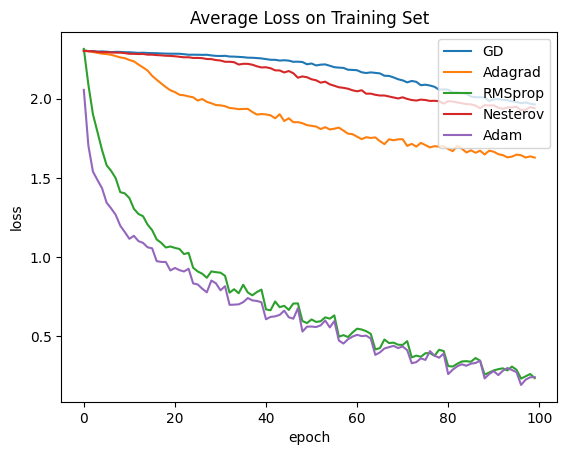

In [ ]:
for i in range(len(optimizer_list)):
    plt.plot(hist_loss_nn[i],label=str(optimizer_names[i]))
plt.title('Average Loss on Training Set')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

Based on the basic CNN architecture (3×32×32 → 32C5 → P2 → 64C5 → P2 → 128C5 → P2 → 1000N → 10N), **Adam optimiser consistently outperforms others**, followed by RMSProp, Adagrad, Nesterov, and batch-normalised gradient descent. This may be because Adam combines the benefits of momentum and adaptive learning rates, allowing faster convergence, while Nesterov’s accelerated gradient anticipates future parameter updates, leading to more informed steps. However, it is important to note that the effectiveness of an optimiser can depend significantly on model architecture and hyperparameter settings, so one should avoid overgeneralising from these outcomes.

For instance, Choi et al. (2019) demonstrated that, with additional tuning of optimisation hyperparameters and weight decay, SGD, Momentum, RMSProp, and Adam achieved nearly identical test error rates. This suggests that while certain optimisers may show better performance under default settings, their effectiveness can shift with proper tuning.

Nevertheless, due to limited computational resources, I did not conduct extensive hyperparameter tuning across different optimisers in this experiment.

###Step 2: Add Dropout at Different Layers & Different Rates



---
With Adam, I will use dropout in the same CNN architecture, adjusting the probability of each unit being dropped in the network. I will also apply dropout to different layers, and compare to identify which one is outperforming. In particular, adding dropout to the max-pooling layer may make the pooling process more stochastic, rather than always selecting the strongest feature. This may potentially mitigate overfitting to dominant features.

Here, dropout will be applied **after convolutional layers**, **pooling layers**, and **fully connected layers**. Dropout rate of **0.1**, **0.3**, **0.5**, **0.7**, **0.9** for each layer will be tested.


In [ ]:
# Tune Dropout for Convolutional Layers
def build_dropout_model_conv(hp):
    model_drop_conv = Sequential()
    model_drop_conv.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=n_features))
    model_drop_conv.add(SpatialDropout2D(hp.Choice('dropout_conv', dropout)))
    model_drop_conv.add(MaxPooling2D(strides=(2, 2)))

    model_drop_conv.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model_drop_conv.add(SpatialDropout2D(hp.Choice('dropout_conv', dropout)))
    model_drop_conv.add(MaxPooling2D(strides=(2, 2)))

    model_drop_conv.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model_drop_conv.add(SpatialDropout2D(hp.Choice('dropout_conv', dropout)))
    model_drop_conv.add(MaxPooling2D(strides=(2, 2)))

    model_drop_conv.add(Flatten())
    model_drop_conv.add(Dense(1000, activation='relu'))
    model_drop_conv.add(Dense(n_classes, activation='softmax'))

    model_drop_conv.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model_drop_conv


# Tune Dropout for Pooling Layers
def build_dropout_model_pool(hp):
    model_drop_pool = Sequential()
    model_drop_pool.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=n_features))
    model_drop_pool.add(MaxPooling2D(strides=(2, 2)))
    model_drop_pool.add(Dropout(hp.Choice('dropout_pool', dropout)))

    model_drop_pool.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model_drop_pool.add(MaxPooling2D(strides=(2, 2)))
    model_drop_pool.add(Dropout(hp.Choice('dropout_pool', dropout)))

    model_drop_pool.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model_drop_pool.add(MaxPooling2D(strides=(2, 2)))
    model_drop_pool.add(Dropout(hp.Choice('dropout_pool', dropout)))

    model_drop_pool.add(Flatten())
    model_drop_pool.add(Dense(1000, activation='relu'))
    model_drop_pool.add(Dense(n_classes, activation='softmax'))

    model_drop_pool.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model_drop_pool


# Tune Dropout for Fully Connected (FC) Layers
def build_dropout_model_fc(hp):
    model_drop_fc = Sequential()
    model_drop_fc.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=n_features))
    model_drop_fc.add(MaxPooling2D(strides=(2, 2)))

    model_drop_fc.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model_drop_fc.add(MaxPooling2D(strides=(2, 2)))

    model_drop_fc.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model_drop_fc.add(MaxPooling2D(strides=(2, 2)))

    model_drop_fc.add(Flatten())
    model_drop_fc.add(Dense(1000, activation='relu'))
    model_drop_fc.add(Dropout(hp.Choice('dropout_fc', dropout)))
    model_drop_fc.add(Dense(n_classes, activation='softmax'))

    model_drop_fc.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model_drop_fc

In [ ]:
# Tuning Dropout in Convolutional Layers
tuner_conv = kt.Hyperband(build_dropout_model_conv, objective='val_accuracy', max_epochs=60, factor=3, directory='store_drop_1', project_name='conv1_drop_1')

# Tuning Dropout in Pooling Layers
tuner_pool = kt.Hyperband(build_dropout_model_pool, objective='val_accuracy', max_epochs=60, factor=3, directory='store_drop_1', project_name='pool2_drop_2')

# Tuning Dropout in Fully Connected Layers
tuner_fc = kt.Hyperband(build_dropout_model_fc, objective='val_accuracy', max_epochs=60, factor=3, directory='store_drop_1', project_name='fc1_drop_1')

# Hyperparameter search for each
tuner_conv.search(data_train, label_train, epochs=70, validation_split=0.2, verbose=1)
tuner_pool.search(data_train, label_train, epochs=70, validation_split=0.2, verbose=1)
tuner_fc.search(data_train, label_train, epochs=70, validation_split=0.2, verbose=1)


Trial 5 Complete [00h 00m 30s]
val_accuracy: 0.6632999777793884

Best val_accuracy So Far: 0.680899977684021
Total elapsed time: 00h 02m 42s


In [ ]:
# Best dropout rates from KerasTuner
best_hps_conv = tuner_conv.get_best_hyperparameters(num_trials=1)[0]
best_hps_pool = tuner_pool.get_best_hyperparameters(num_trials=1)[0]
best_hps_fc = tuner_fc.get_best_hyperparameters(num_trials=1)[0]

# Store best dropout rates
best_dropout_conv = best_hps_conv.get('dropout_conv')
best_dropout_pool = best_hps_pool.get('dropout_pool')
best_dropout_fc = best_hps_fc.get('dropout_fc')

print("Best Dropout Rate for Convolutional Layers:", best_dropout_conv)
print("Best Dropout Rate for Pooling Layers:", best_dropout_pool)
print("Best Dropout Rate for Fully Connected Layers:", best_dropout_fc)

Best Dropout Rate for Convolutional Layers: 0.1
Best Dropout Rate for Pooling Layers: 0.1
Best Dropout Rate for Fully Connected Layers: 0.30000000000000004


In [ ]:
# Store training histories
histories = {}

# Train model using best convolutional dropout
print("\nTraining Model with Best Conv Dropout...")
best_model_conv = build_dropout_model_conv(kt.HyperParameters())
best_model_conv.get_layer(index=1).rate = best_dropout_conv
history_conv = best_model_conv.fit(data_train, label_train, epochs=n_epoch, batch_size=batch_size, validation_split=0.2, steps_per_epoch=50, shuffle=True)
histories["Conv Dropout"] = history_conv

# Train model using best pooling dropout
print("\nTraining Model with Best Pool Dropout...")
best_model_pool = build_dropout_model_pool(kt.HyperParameters())
best_model_pool.get_layer(index=3).rate = best_dropout_pool
history_pool = best_model_pool.fit(data_train, label_train, epochs=n_epoch, batch_size=batch_size, validation_split=0.2, steps_per_epoch=50, shuffle=True)
histories["Pool Dropout"] = history_pool

# Train model using best fully connected dropout
print("\nTraining Model with Best FC Dropout...")
best_model_fc = build_dropout_model_fc(kt.HyperParameters())
best_model_fc.get_layer(index=6).rate = best_dropout_fc
history_fc = best_model_fc.fit(data_train, label_train, epochs=n_epoch, batch_size=batch_size, validation_split=0.2, steps_per_epoch=50, shuffle=True)
histories["FC Dropout"] = history_fc



Training Model with Best Conv Dropout...
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.1647 - loss: 2.2021 - val_accuracy: 0.3213 - val_loss: 1.8429
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3298 - loss: 1.8117 - val_accuracy: 0.3903 - val_loss: 1.6485
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4135 - loss: 1.6303 - val_accuracy: 0.4719 - val_loss: 1.4646
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4627 - loss: 1.5063 - val_accuracy: 0.4899 - val_loss: 1.3905
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4947 - loss: 1.4175 - val_accuracy: 0.5291 - val_loss: 1.3345
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5165 - loss: 1.3502 - val_accuracy: 0.5511 - val_loss: 1.2404
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5240 - loss: 1.3153 - val_accuracy: 0.5525 - val_loss: 1.2408
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accurac

**Please note that I intentionally use validation set to estimate and compare dropout's ability in different layers.**

In [ ]:
for name, history in histories.items():
    history.history['val_accuracy']

Text(0.5, 1.0, 'Validation Accuracy and Loss Comparison')

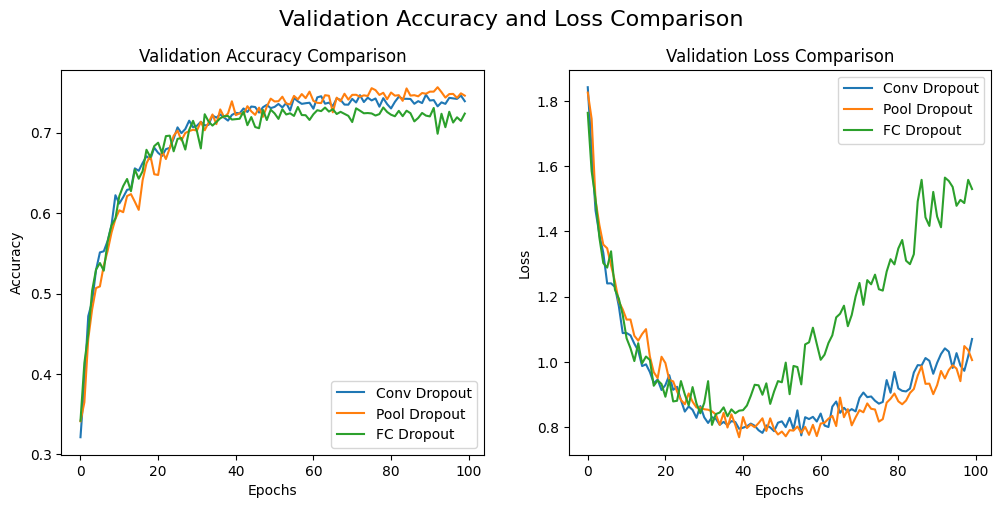

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for name, history in histories.items():
    ax1.plot(history.history['val_accuracy'], label=name)
ax1.set_title("Validation Accuracy Comparison")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()

for name, history in histories.items():
    ax2.plot(history.history['val_loss'], label=name)
ax2.set_title("Validation Loss Comparison")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()

fig.suptitle("Validation Accuracy and Loss Comparison", fontsize=16, y=1.00)

Using convolutional, max-pooling, and fully connected dropout individually enhances performance, though fully-connected dropout appears to be less beneficialㅡlower validation accuracy and overfitting presented, despite its common practice. **Interestingly, applying dropout in pooling layers yield best validation accuracy and effectively address overfitting.** Given simple CNN architecture, relatively lower dropout rate (0.3 for FC layers and 0.1 for pool & conv layers) seems to be most effective. Nevertheless, for deeper or wider architecture, the best dropout rate could be different.

# Problem 2
## CIFAR10 Image Classification

## 1. First Architecture

Since CIFAR-10 has significant intra-class variation, I decided to use **a deeper network to capture non-linear patterns**. To achieve this, I incorporate eight convolutional layers, three pooling layers, and two fully connected layers. Additionally, **I reduce the kernel size from 5×5 to 3×3 to reduce computational costs and enhance model performance**. This is inspired by VGGNet, which demonstrates that stacking n convolutional layers with 3×3 filters and stride 1 achieves the same effective receptive field as a single convolutional layer with a (2n+1)×(2n+1) kernel. Despite using more layers, the total parameter count remains comparable, and deep, narrow networks generally outperform shallower ones with larger kernels. More layers introduce additional non-linearities, enhancing the model’s expressive power for capturing complex patterns. Nevertheless, I did not put too much layers to avoid vanishing gradient issues.

Moreover, in the previous plot (validation loss), after around 30-40 epochs, the validation loss increases. This implies that the model begins to capture noise in the training data rather than learning generalisable patterns, an indication of overfitting.

Given CIFAR-10 is considered to be independent and identically distributed (i.i.d.), **batch normalization** serves as an implicit form of regularisation, stabilising the training process by improving gradient flow—mitigating issues like vanishing or exploding gradients—and enabling the use of higher learning rates for faster convergence. In convolutional layers, batch normalization is applied per channel across all spatial locations, aligning with the assumption of translation invariance in convolutions. It is inserted after the convolutional layer and before the activation function. Moreover, the **ReLU** is used for the activation function in convolutional and fully connected layers, while softmax is applied in the output layer to produce probability distributions. Commonly used sigmoid and tanh activations are not used due to their susceptibility to the vanishing gradient problem. Lastly, I adopt **Learning Rate Scheduler**, which reduces the learning rate by 0.05 when validation loss stops improving with 2 patience. This helps the model converge more effectively by lowering the learning rate when training reaches a plateau. After trying out multiple patience and factor, 2 and 0.05 respectively produces higher validation accuracy.


* Convolutional Filters Size : 3x3
* Convolutional Stride : (1, 1)
* Max-Pool Size : 2x2
* Max-Pool Stride : (2, 2)
* Activation Function : ReLU
* Pooling Dropout = 0.1
* Adam
* 3x32x32-32C5-32C5-P2-64C5-64C5-P2-128C5-128C5-P2-1000N-10N


**Optimisation Techniques:**
* Batch normalization
* Early stopping
* Weight initialisation (he normal initialisation)
* Learning Rate Scheduler (factor = 0.05, patience = 2)



In [ ]:
def build_opt_model1():
    model_opt1 = Sequential()

    model_opt1.add(Conv2D(64, (3, 3), padding='same', input_shape=n_features, kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001)))
    model_opt1.add(BatchNormalization())
    model_opt1.add(Activation('relu'))
    model_opt1.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001)))
    model_opt1.add(BatchNormalization())
    model_opt1.add(Activation('relu'))
    model_opt1.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001)))
    model_opt1.add(BatchNormalization())
    model_opt1.add(Activation('relu'))
    model_opt1.add(MaxPooling2D(strides=(2, 2)))
    model_opt1.add(Dropout(0.1))

    model_opt1.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001)))
    model_opt1.add(BatchNormalization())
    model_opt1.add(Activation('relu'))
    model_opt1.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001)))
    model_opt1.add(BatchNormalization())
    model_opt1.add(Activation('relu'))
    model_opt1.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001)))
    model_opt1.add(BatchNormalization())
    model_opt1.add(Activation('relu'))
    model_opt1.add(MaxPooling2D(strides=(2, 2)))
    model_opt1.add(Dropout(0.1))

    model_opt1.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001)))
    model_opt1.add(BatchNormalization())
    model_opt1.add(Activation('relu'))
    model_opt1.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001)))
    model_opt1.add(BatchNormalization())
    model_opt1.add(Activation('relu'))
    model_opt1.add(MaxPooling2D(strides=(2, 2)))
    model_opt1.add(Dropout(0.1))

    model_opt1.add(Flatten())
    model_opt1.add(Dense(1000, use_bias=False, kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001)))
    model_opt1.add(BatchNormalization())
    model_opt1.add(Activation('relu'))
    model_opt1.add(Dropout(0.3))

    model_opt1.add(Dense(1000, kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001)))
    model_opt1.add(BatchNormalization())
    model_opt1.add(Activation('relu'))
    model_opt1.add(Dropout(0.3))
    model_opt1.add(Dense(n_classes, activation='softmax'))

    model_opt1.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy', TopKCategoricalAccuracy(k=5)])

    return model_opt1

# Build the model
model_opt1 = build_opt_model1()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=2, min_lr=1e-9)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Summary
model_opt1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_59 (Conv2D)                   │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 16, 16, 128)         │             5

 Total params: 6,449,282 (24.60 MB)

 Trainable params: 6,443,106 (24.58 MB)

 Non-trainable params: 6,176 (24.12 KB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


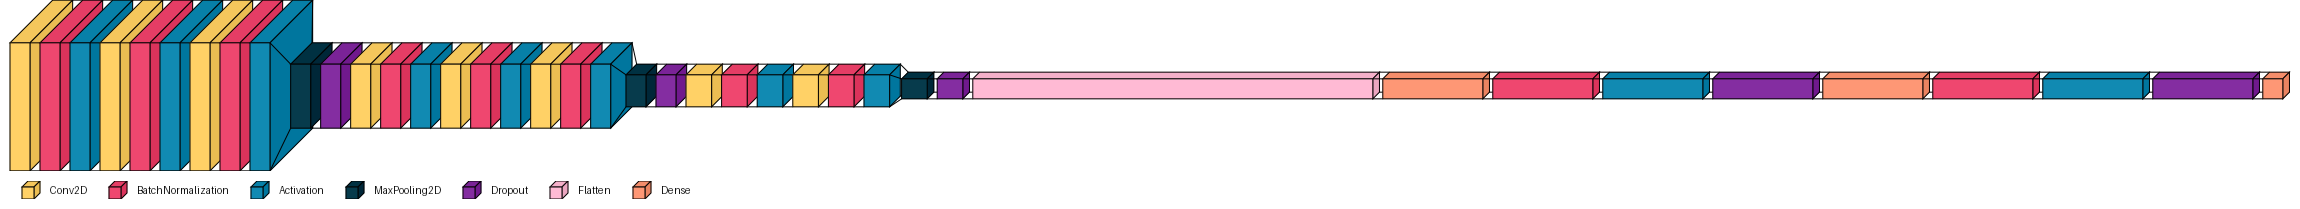

In [ ]:
visualkeras.layered_view(model_opt1, legend=True)

In [ ]:
class TestErrorCallback(Callback):
    def __init__(self, test_data, test_labels):
        super().__init__()
        self.test_data = test_data
        self.test_labels = test_labels
        self.test_losses = []
        self.test_top1_errors = []
        self.test_top5_errors = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc, test_top5_acc = self.model.evaluate(self.test_data, self.test_labels, verbose=0)

        # Store values for later plotting
        self.test_losses.append(test_loss)
        self.test_top1_errors.append(1 - test_acc)
        self.test_top5_errors.append(1 - test_top5_acc)


test_error_callback_opt1 = TestErrorCallback(data_test, label_test)


In [ ]:
# Start training timer
start = time.time()

# Train the model
history_opt1 = model_opt1.fit(data_train, label_train, epochs=n_epoch, batch_size=128,
                        validation_split=0.2, callbacks=[reduce_lr, early_stopping, test_error_callback_opt1])

# End training timer
end = time.time()

# Calculate and print execution time
time_es = (end - start) / 60
print('Minutes to run: ', time_es)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 113ms/step - accuracy: 0.4072 - loss: 2.3686 - top_k_categorical_accuracy: 0.8768 - val_accuracy: 0.5137 - val_loss: 2.0963 - val_top_k_categorical_accuracy: 0.9437 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 64ms/step - accuracy: 0.6671 - loss: 1.5680 - top_k_categorical_accuracy: 0.9709 - val_accuracy: 0.6482 - val_loss: 1.6142 - val_top_k_categorical_accuracy: 0.9628 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.7507 - loss: 1.2901 - top_k_categorical_accuracy: 0.9860 - val_accuracy: 0.6991 - val_loss: 1.4491 - val_top_k_categorical_accuracy: 0.9750 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.8040 - loss: 1.1033 - top_k_categorical_accuracy: 0.9909 - val_accuracy: 0.7411 - val_loss: 1.2963 - val_top_k_categorical_accuracy: 0.9822 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 

In [ ]:
test_loss_opt1 = test_error_callback_opt1.test_losses
test_top1_error_opt1 = test_error_callback_opt1.test_top1_errors
test_top5_error_opt1 = test_error_callback_opt1.test_top5_errors

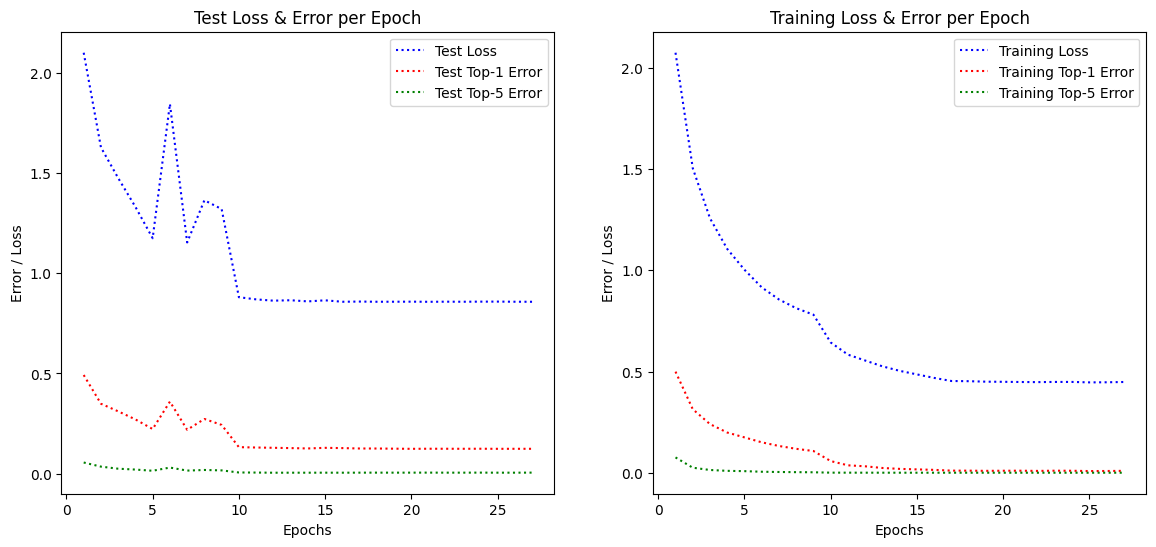

In [ ]:
epochs_total1 = len(test_error_callback_opt1.test_losses)
epochs1 = range(1, epochs_total1 + 1)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot test loss, top-1 error, and top-5 error
ax[0].plot(epochs1, test_loss_opt1, label='Test Loss', color='blue', linestyle='dotted')
ax[0].plot(epochs1, test_top1_error_opt1, label='Test Top-1 Error', color='red', linestyle='dotted')
ax[0].plot(epochs1, test_top5_error_opt1, label='Test Top-5 Error', color='green', linestyle='dotted')
ax[0].set_title('Test Loss & Error per Epoch')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error / Loss')
ax[0].legend()

# Plot training loss, top-1 error, and top-5 error
ax[1].plot(epochs1, history_opt1.history['loss'], label='Training Loss', color='blue', linestyle='dotted')
ax[1].plot(epochs1, [1 - acc for acc in history_opt1.history['accuracy']],
           label='Training Top-1 Error', color='red', linestyle='dotted')
ax[1].plot(epochs1, [1 - acc for acc in history_opt1.history['top_k_categorical_accuracy']],
           label='Training Top-5 Error', color='green', linestyle='dotted')
ax[1].set_title('Training Loss & Error per Epoch')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error / Loss')
ax[1].legend()
plt.show()

### 2. Second Architecture
This architecture utilises **Inception blocks** for multi-resolution feature extraction at all levels. Previous model uses relatively small size of kernel but put deeper layers, which produces decent performance. Nevertheless, the Inception approach applies multiple filters of different sizes in parallel to the same input, allowing the network to learn both fine and coarse features due to the diversity in receptive fields. Although this multi-branch strategy enriches feature representation, it introduces greater computational demands. To mitigate this, 1×1 convolutions are incorporated as bottleneck layers to reduce channel dimensionality while retaining critical information. For the 5×5 and 7×7 convolutional layer (c3, c4), a relatively smaller number of channels is used to reduce computational complexity. Moreover, instead of using fully-connected layer at the end of the architecture, I use averagepooling to reduce computational complexity. This pooling will spatially average across each feature map and promote sparser connections, eventually leading to more efficient computation. **Ultimately, the trainable parameters drastically decrease from 6,443,106 to 2,998,210**.


Furthermore, **AdamW** is chosen as the optimizer, as it decouples weight decay from the gradient update step, potentially leading to better regularization compared to standard Adam. To mitigate vanishing gradient issues when x<0, **Leaky ReLU** is adopted as the activation function. Additionally, fully connected layers at the end of the architecture are replaced with average pooling layers to reduce the number of parameters and minimize overfitting.

Notably, **auxiliary classifiers are not included in this architecture**. While they were originally introduced to prevent vanishing gradients in deep networks, subsequent research has shown that the contribution of auxiliary classifiers to accuracy improvement has been reported as minimal.


* Convolutional Filters Size: 3×3, 5×5 7×7 (Inception blocks)
* Convolutional Stride: (1,1)
* Activation Function: LeakyReLU (α=0.3)
* Kernel Initialization: He Normal Initialization
* Regularization: L2 Regularization (0.0001)
* Max-Pooling Size: 2×2
* Max-Pooling Stride: (2,2)
* Global Average Pooling: Final pooling before Dense layer


**Optimisation Techniques:**
* Layer normalization
* Early stopping
* Weight initialisation (he normal initialisation)
* Exponential decay

In [ ]:
class TestErrorCallback2(Callback):
    def __init__(self, test_data, test_labels):
        super().__init__()
        self.test_data = test_data
        self.test_labels = test_labels
        self.test_losses = []
        self.test_top1_errors = []
        self.test_top5_errors = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc, test_top5_acc = self.model.evaluate(self.test_data, self.test_labels, verbose=0)

        # Store values for later plotting
        self.test_losses.append(test_loss)
        self.test_top1_errors.append(1 - test_acc)
        self.test_top5_errors.append(1 - test_top5_acc)

test_error_callback_opt2 = TestErrorCallback2(data_test, label_test)

In [ ]:
class Inception(tf.keras.Model):
    def __init__(self, c1, c2, c3, c4, c5):
        super().__init__()
        self.b1 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(c1, (1, 1), kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(negative_slope=0.3)])

        self.b2 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(c2[0], (1, 1), kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(negative_slope=0.3),

            tf.keras.layers.Conv2D(c2[1], (3, 3), padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(negative_slope=0.3)])

        self.b3 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(c3[0], (1, 1), kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(negative_slope=0.3),

            tf.keras.layers.Conv2D(c3[1], (5, 5), padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(negative_slope=0.3)])

        self.b4 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(c4[0], (1, 1), kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(negative_slope=0.3),

            tf.keras.layers.Conv2D(c4[1], (7, 7), padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(negative_slope=0.3)])

        self.b5 = tf.keras.Sequential([
            tf.keras.layers.MaxPooling2D((3, 3), strides=1, padding='same'),
            tf.keras.layers.Conv2D(c5, (1, 1), kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(negative_slope=0.3)])

    def call(self, x):
        b1 = self.b1(x)
        b2 = self.b2(x)
        b3 = self.b3(x)
        b4 = self.b4(x)
        b5 = self.b5(x)
        return tf.keras.layers.Concatenate()([b1, b2, b3, b4, b5])



In [ ]:
def build_opt_model2():
    model_opt2 = tf.keras.Sequential([
        # BLOCK 1
        tf.keras.layers.Conv2D(64, (3, 3), padding='same' , input_shape = n_features, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(negative_slope=0.3),

        # BLOCK 2
        tf.keras.layers.Conv2D(64, (1,1)),
        tf.keras.layers.LeakyReLU(negative_slope=0.3),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(negative_slope=0.3),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        tf.keras.layers.Dropout(0.1),

        # BLOCK 3
        Inception(64, (96, 128), (16, 32), (8, 16), 32),
        Inception(64, (96, 128), (16, 32), (8, 16), 32),
        Inception(128, (128, 192), (32, 96), (8, 16), 64),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        tf.keras.layers.Dropout(0.2),

        Inception(192, (96, 208), (16, 48), (8, 16), 64),
        Inception(160, (112, 224), (24, 64), (8, 16), 64),
        Inception(160, (112, 224), (24, 64), (8, 16), 64),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        tf.keras.layers.Dropout(0.2),

        Inception(256, (160, 320), (32, 128), (8, 16), 128),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_classes, activation='softmax')])

    model_opt2.compile(optimizer='AdamW', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

    return model_opt2

# Build the model
model_opt2 = build_opt_model2()

# Summary
model_opt2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception (Inception)                │ (None, 16, 16, 272)         │         145,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_1 (Inception)              │ (None, 16, 16, 272)         │         190,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_2 (Inception)              │ (None, 16, 16, 496)         │         405,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 496)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 496)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_3 (Inception)              │ (None, 8, 8, 528)           │         394,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_4 (Inception)              │ (None, 8, 8, 528)           │         468,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_5 (Inception)              │ (None, 8, 8, 528)           │         468,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 528)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 528)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,007,442 (11.47 MB)

 Trainable params: 2,998,210 (11.44 MB)

 Non-trainable params: 9,232 (36.06 KB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


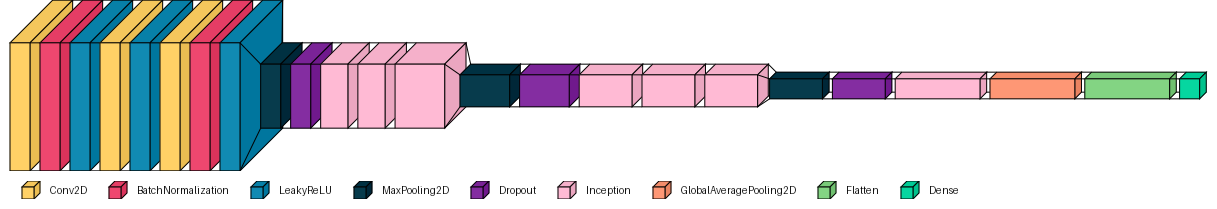

In [ ]:
visualkeras.layered_view(model_opt2, legend=True)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=2, min_lr=1e-9)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Start training timer
import time
start = time.time()

# Train the model
history_inception = model_opt2.fit(data_train, label_train, epochs=n_epoch, batch_size=128, validation_split=0.2, callbacks=[reduce_lr, early_stopping, test_error_callback_opt2])

# End training timer
end = time.time()
time_es = (end - start) / 60
print('Minutes to run: ', time_es)


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 220s 386ms/step - accuracy: 0.4686 - loss: 2.3854 - top_k_categorical_accuracy: 0.9052 - val_accuracy: 0.4991 - val_loss: 2.2664 - val_top_k_categorical_accuracy: 0.9499 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 134ms/step - accuracy: 0.7191 - loss: 1.6197 - top_k_categorical_accuracy: 0.9795 - val_accuracy: 0.6802 - val_loss: 1.6919 - val_top_k_categorical_accuracy: 0.9558 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.7869 - loss: 1.3137 - top_k_categorical_accuracy: 0.9881 - val_accuracy: 0.7364 - val_loss: 1.4298 - val_top_k_categorical_accuracy: 0.9714 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 146ms/step - accuracy: 0.8230 - loss: 1.1272 - top_k_categorical_accuracy: 0.9914 - val_accuracy: 0.7736 - val_loss: 1.2156 - val_top_k_categorical_accuracy: 0.9860 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 141ms/step - accur

In [ ]:
test_loss_opt2 = test_error_callback_opt2.test_losses
test_top1_error_opt2 = test_error_callback_opt2.test_top1_errors
test_top5_error_opt2 = test_error_callback_opt2.test_top5_errors

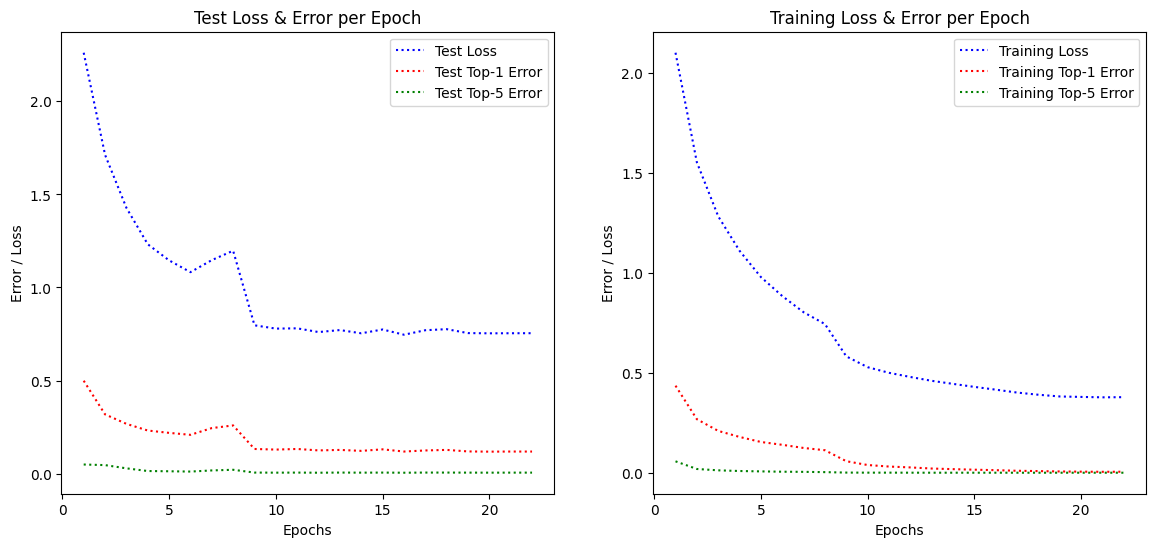

In [ ]:
epochs_total2 = len(test_error_callback_opt2.test_losses)
epochs2 = range(1, epochs_total2 + 1)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Plot test loss, top-1 error, and top-5 error
ax[0].plot(epochs2, test_loss_opt2, label='Test Loss', color='blue', linestyle='dotted')
ax[0].plot(epochs2, test_top1_error_opt2, label='Test Top-1 Error', color='red', linestyle='dotted')
ax[0].plot(epochs2, test_top5_error_opt2, label='Test Top-5 Error', color='green', linestyle='dotted')
ax[0].set_title('Test Loss & Error per Epoch')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error / Loss')
ax[0].legend()

# Plot training loss, top-1 error, and top-5 error
ax[1].plot(epochs2, history_inception.history['loss'], label='Training Loss', color='blue', linestyle='dotted')
ax[1].plot(epochs2, [1 - acc for acc in history_inception.history['accuracy']],
           label='Training Top-1 Error', color='red', linestyle='dotted')
ax[1].plot(epochs2, [1 - acc for acc in history_inception.history['top_k_categorical_accuracy']],
           label='Training Top-5 Error', color='green', linestyle='dotted')
ax[1].set_title('Training Loss & Error per Epoch')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error / Loss')
ax[1].legend()
fig.suptitle("Architecture 2", fontsize=18, y=1.02)
plt.show()

### 3. Third Architecture



This architecture is inspired by ResNet-18 (with four residual block, two for each) without the use of bottleneck blocks (1x1, 3x3, 1x1).

The initial Conv2D in ResNet is usually a 7x7 with stride 2 for larger images, followed by MaxPool. But the input of CIFAR-10 is smaller, I use relatively small size of kernel (3x3) and did not put max pooling (as the absence yield better validation accuracy)

Here is the several other distinctions:

1. Downsampling is done via MaxPooling after residual blocks instead of using stride=2 in the first Conv2D of a residual block when increasing filters. This changes how the spatial dimensions are reduced.

2. Dropout is applied at MaxPooling, which is not present in the original ResNet.

3. L2 regularization is used instead of tuning weight decay.

4. Adam is used instead of SGD with momentum of 0.9 in original ResNet-18.

5. I manually designed learning rate to reduce error rate after 10-12 epochs (where little improvement is observed in architecture 1 and 2).

The original ResNet starts with a learning rate of 0.1, reducing it by a factor of 10 at 32k and 48k iterations, and stopping at 64k iterations. Due to its unique architecture and optimiser, this model begins with a learning rate of 0.1 for the first epoch, then decreases to 0.001 until epoch 5. The learning rate schedule is illustrated in the graph below.

In [ ]:
class TestErrorCallback3(Callback):
    def __init__(self, test_data, test_labels):
        super().__init__()
        self.test_data = test_data
        self.test_labels = test_labels
        self.test_losses = []
        self.test_top1_errors = []
        self.test_top5_errors = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc, test_top5_acc = self.model.evaluate(self.test_data, self.test_labels, verbose=0)

        # Store values for later plotting
        self.test_losses.append(test_loss)
        self.test_top1_errors.append(1 - test_acc)
        self.test_top5_errors.append(1 - test_top5_acc)

test_error_callback_opt3 = TestErrorCallback3(data_test, label_test)

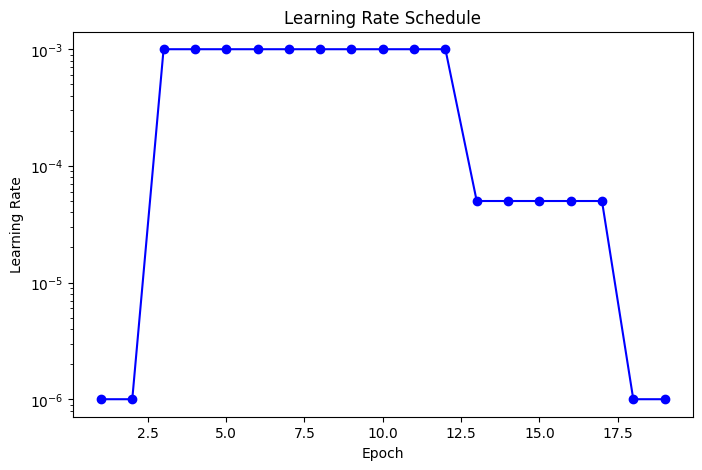

In [ ]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.000001
    elif epoch <= 12:
        return 0.001
    elif epoch <= 17:
        return 5e-5
    elif epoch <= 20:
        return 1e-6
    elif epoch <= 25:
        return 5e-7
    return 1e-8

lrate = LearningRateScheduler(scheduler)

epochs = np.arange(1, 20)
learning_rates = [scheduler(epoch) for epoch in epochs]

# Learning rate schedule plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, learning_rates, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.yscale("log")
plt.show()

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_opt_model3():
    inputs = layers.Input(shape=n_features)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.0001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = residual_block(x, 512)
    x = residual_block(x, 512)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)

    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model_opt3 = keras.Model(inputs, outputs)
    model_opt3.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5)])

    return model_opt3

# Build the ResNet model
model_opt3 = build_opt_model3()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Summary
model_opt3.summary()

start = time.time()

# Train the model
history_model_opt3 = model_opt3.fit(data_train, label_train, epochs=n_epoch, batch_size=128, validation_split=0.2, callbacks=[lrate, early_stopping, test_error_callback_opt3])
# End training timer
end = time.time()
time_es = (end - start) / 60
print('Minutes to run: ', time_es)




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 32, 32, 64)     │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 32, 32, 64)     │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 32, 32, 64)     │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 32, 32, 64)     │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 32, 32, 64)     │              0 │ add_8[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 32, 32, 64)     │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)   

 Total params: 11,203,722 (42.74 MB)

 Trainable params: 11,194,122 (42.70 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 200ms/step - accuracy: 0.1226 - loss: 3.5381 - top_k_categorical_accuracy: 0.5591 - val_accuracy: 0.1417 - val_loss: 3.2569 - val_top_k_categorical_accuracy: 0.6078 - learning_rate: 1.0000e-06
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 141ms/step - accuracy: 0.1937 - loss: 3.1728 - top_k_categorical_accuracy: 0.6846 - val_accuracy: 0.2002 - val_loss: 3.1106 - val_top_k_categorical_accuracy: 0.7046 - learning_rate: 1.0000e-06
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step - accuracy: 0.2427 - loss: 3.0428 - top_k_categorical_accuracy: 0.7525 - val_accuracy: 0.2343 - val_loss: 3.0418 - val_top_k_categorical_accuracy: 0.7393 - learning_rate: 1.0000e-06
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 134ms/step - accuracy: 0.4159 - loss: 2.8593 - top_k_categorical_accuracy: 0.8800 - val_accuracy: 0.5651 - val_loss: 2.2840 - val_top_k_categorical_accuracy: 0.9419 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/s

In [ ]:
test_loss_opt3 = test_error_callback_opt3.test_losses
test_top1_error_opt3 = test_error_callback_opt3.test_top1_errors
test_top5_error_opt3 = test_error_callback_opt3.test_top5_errors

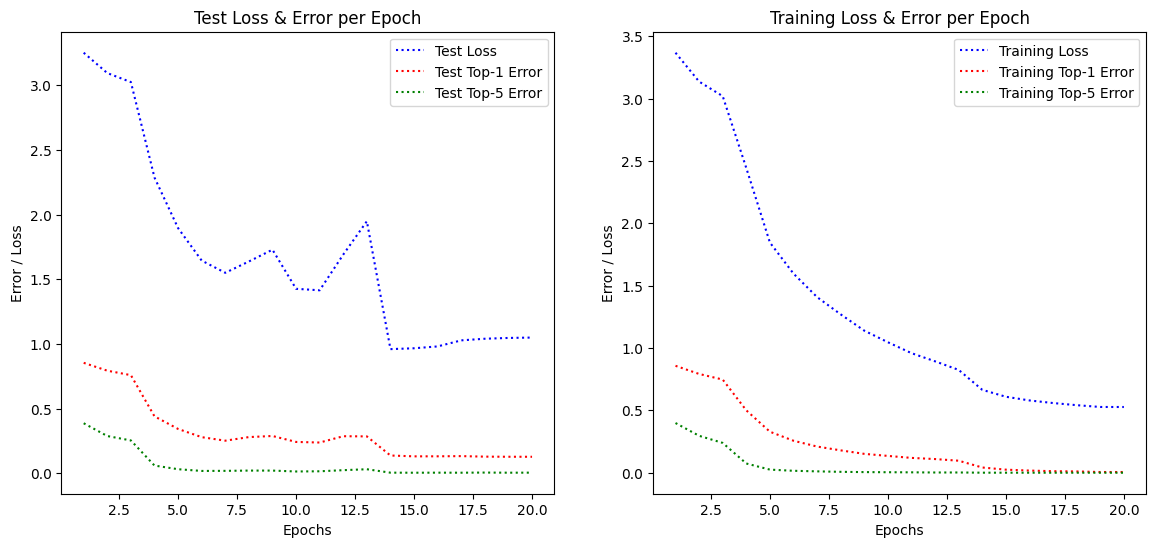

In [ ]:
epochs_total3 = len(test_error_callback_opt3.test_losses)
epochs3 = range(1, epochs_total3 + 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Plot test loss, top-1 error, and top-5 error
ax[0].plot(epochs3, test_loss_opt3, label='Test Loss', color='blue', linestyle='dotted')
ax[0].plot(epochs3, test_top1_error_opt3, label='Test Top-1 Error', color='red', linestyle='dotted')
ax[0].plot(epochs3, test_top5_error_opt3, label='Test Top-5 Error', color='green', linestyle='dotted')
ax[0].set_title('Test Loss & Error per Epoch')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error / Loss')
ax[0].legend()

# Plot training loss, top-1 error, and top-5 error
ax[1].plot(epochs3, history_model_opt3.history['loss'], label='Training Loss', color='blue', linestyle='dotted')
ax[1].plot(epochs3, [1 - acc for acc in history_model_opt3.history['accuracy']],
           label='Training Top-1 Error', color='red', linestyle='dotted')
ax[1].plot(epochs3, [1 - acc for acc in history_model_opt3.history['top_k_categorical_accuracy']],
           label='Training Top-5 Error', color='green', linestyle='dotted')
ax[1].set_title('Training Loss & Error per Epoch')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error / Loss')
ax[1].legend()
plt.show()

# Reference

Choi, D. et al. (2019) “On empirical comparisons of optimizers for deep learning,” arXiv [cs.LG]. Available at: http://arxiv.org/abs/1910.05446.